# Stability Analysis for Neural Network Controllers

This notebook implements the stability criterion from the paper:

**Goal**: Certify that the closed-loop Jacobian $J_{cl}$ is Hurwitz (all eigenvalues have negative real parts)
based on sampled perturbation responses.

## Method Overview

1. Sample $N$ perturbation directions $d^{(k)}$ on the unit sphere
2. For each direction, compute forward difference: $y^{(k)} = \frac{F(hd^{(k)}) - F(0)}{h}$
3. Estimate Jacobian: $\hat{J}_{cl} = YD^T(DD^T)^{-1}$
4. Estimate Hessian bound $L_2$ from second derivatives
5. Check stability criterion: $\kappa(V) \cdot \frac{1}{2} L_2 h \frac{n}{\sqrt{N}} \leq \hat{\lambda}$

where $\hat{\lambda} = -\max_i \text{Re}(\hat{\lambda}_i)$ is the stability margin.

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["text.usetex"] = True
plt.rcParams["font.size"] = 12

## Load Stability Samples

In [16]:
# Path to stability samples (update this path to your checkpoint)
SAMPLES_PATH = "/home/apptronik/isaaclab_manager/resources/IsaacLab/source/nonlinear_ct/artifacts/point_mass/2025-11-27_12-15-37/exported/stability/stability_samples.pt"

data = torch.load(SAMPLES_PATH)

print(f"Perturbation radius h: {data['h']}")
print(f"Number of samples N: {data['N']}")
print(f"State dimension n: {data['state_dim']}")
print(f"Observation dimension: {data['obs_dim']}")
print(f"Action dimension: {data['act_dim']}")

Perturbation radius h: 0.01
Number of samples N: 5000
State dimension n: 4
Observation dimension: 4
Action dimension: 2


## Extract Data

In [17]:
h = data["h"]
N = data["N"]
n = data["obs_dim"]  # State dimension in observation space

# Directions matrix D: (n, N) where each column is a direction
# Note: We use observation-space directions derived from joint-space perturbations
# The directions in data are in joint space, but we work in observation space
D_joint = data["directions"].T  # (state_dim, N)

# Response at origin
F_zero = data["F_zero"]["obs_t1"]  # (obs_dim,)

# Responses to positive and negative perturbations
F_pos = data["F_pos"]["obs_t1"]  # (N, obs_dim)
F_neg = data["F_neg"]["obs_t1"]  # (N, obs_dim)

# Initial observations (to get the observation-space directions)
obs_pos_t0 = data["F_pos"]["obs_t0"]  # (N, obs_dim)
obs_neg_t0 = data["F_neg"]["obs_t0"]  # (N, obs_dim)
obs_zero_t0 = data["F_zero"]["obs_t0"]  # (obs_dim,)

print(f"F_zero shape: {F_zero.shape}")
print(f"F_pos shape: {F_pos.shape}")
print(f"F_neg shape: {F_neg.shape}")

F_zero shape: torch.Size([4])
F_pos shape: torch.Size([5000, 4])
F_neg shape: torch.Size([5000, 4])


## Compute Observation-Space Directions

The perturbations were applied in joint space. We need the effective directions in observation space:
$$d_{obs}^{(k)} = \frac{z_0^{+,k} - z_0^{0}}{h}$$

where $z_0^{+,k}$ is the initial observation for perturbation $+hd^{(k)}$.

In [18]:
# Compute observation-space directions from the actual initial observations
D_obs = ((obs_pos_t0 - obs_zero_t0) / h).T  # (obs_dim, N)

# Normalize directions (they should already be roughly unit norm if h is small)
D_obs_norms = D_obs.norm(dim=0, keepdim=True)
D_obs_normalized = D_obs / (D_obs_norms + 1e-10)

print(f"D_obs shape: {D_obs.shape}")
print(f"Direction norms - min: {D_obs_norms.min():.4f}, max: {D_obs_norms.max():.4f}, mean: {D_obs_norms.mean():.4f}")

D_obs shape: torch.Size([4, 5000])
Direction norms - min: 0.9991, max: 1.0008, mean: 1.0000


## Step 1: Compute Forward Differences

$$y^{(k)} = \frac{F(hd^{(k)}) - F(0)}{h}$$

where $F(z)$ is the closed-loop dynamics mapping initial state $z$ to next state.

In [19]:
# Forward differences: Y = (F(+hd) - F(0)) / h
Y = ((F_pos - F_zero) / h).T  # (obs_dim, N)

print(f"Y shape: {Y.shape}")
print(f"Y norm range: [{Y.norm(dim=0).min():.4f}, {Y.norm(dim=0).max():.4f}]")

Y shape: torch.Size([4, 5000])
Y norm range: [0.9872, 1.0122]


## Step 2: Estimate Jacobian

From the estimator model $Y = J_{cl} D + R$, we have:
$$\hat{J}_{cl} = Y D^T (D D^T)^{-1}$$

This requires $DD^T$ to be invertible, i.e., the directions span $\mathbb{R}^n$.

In [20]:
# Use observation-space directions
D = D_obs  # (n, N)

# Compute DD^T
DDT = D @ D.T  # (n, n)

# Check condition number of DD^T
eigvals_DDT = torch.linalg.eigvalsh(DDT)
cond_DDT = eigvals_DDT.max() / eigvals_DDT.min()
print(f"Condition number of DD^T: {cond_DDT:.4f}")
print(f"Eigenvalues of DD^T: {eigvals_DDT}")

# Estimate Jacobian: J_hat = Y @ D^T @ (D @ D^T)^{-1}
DDT_inv = torch.linalg.inv(DDT)
J_hat = Y @ D.T @ DDT_inv  # (n, n)

print(f"\nEstimated Jacobian J_hat shape: {J_hat.shape}")
print(f"J_hat:\n{J_hat}")

Condition number of DD^T: 1.0459
Eigenvalues of DD^T: tensor([1225.5831, 1232.4917, 1260.1366, 1281.8130])

Estimated Jacobian J_hat shape: torch.Size([4, 4])
J_hat:
tensor([[ 1.0000e+00, -1.0099e-05,  1.9942e-02,  2.0140e-05],
        [-1.3856e-05,  1.0000e+00, -1.9069e-04,  2.0005e-02],
        [ 4.4419e-04,  1.3200e-04,  9.9760e-01,  1.9143e-03],
        [-8.5055e-04, -9.0226e-05, -8.7624e-03,  1.0003e+00]])


## Step 3: Eigenvalue Analysis of $\hat{J}_{cl}$

In [21]:
# Compute eigenvalues and eigenvectors of J_hat
eigvals, eigvecs = torch.linalg.eig(J_hat)

print("Eigenvalues of J_hat:")
for i, ev in enumerate(eigvals):
    print(f"  λ_{i+1} = {ev.real:.6f} + {ev.imag:.6f}j")

# Stability margin: negative of the maximum real part
max_real = eigvals.real.max().item()
lambda_hat = -max_real

print(f"\nMax real part: {max_real:.6f}")
print(f"Stability margin λ̂ = {lambda_hat:.6f}")

if max_real < 0:
    print("\n✓ J_hat appears to be Hurwitz (all eigenvalues have negative real parts)")
else:
    print("\n✗ J_hat is NOT Hurwitz (has eigenvalues with non-negative real parts)")

Eigenvalues of J_hat:
  λ_1 = 1.001025 + 0.003851j
  λ_2 = 1.001025 + -0.003851j
  λ_3 = 0.999525 + 0.000000j
  λ_4 = 0.996308 + 0.000000j

Max real part: 1.001025
Stability margin λ̂ = -1.001025

✗ J_hat is NOT Hurwitz (has eigenvalues with non-negative real parts)


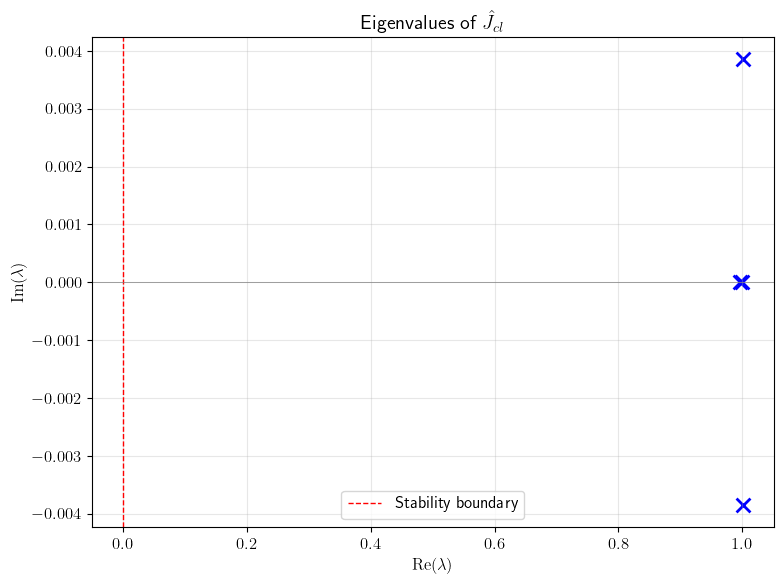

In [29]:
# Plot eigenvalues in complex plane
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(eigvals.real.numpy(), eigvals.imag.numpy(), s=100, c='blue', marker='x', linewidths=2)
ax.axvline(x=0, color='red', linestyle='--', linewidth=1, label='Stability boundary')
ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)

ax.set_xlabel(r'$\mathrm{Re}(\lambda)$')
ax.set_ylabel(r'$\mathrm{Im}(\lambda)$')
ax.set_title(r'Eigenvalues of $\hat{J}_{cl}$')
ax.legend()
ax.grid(True, alpha=0.3)
# ax.set_aspect('equal')

plt.tight_layout()
plt.show()

## Step 4: Estimate Hessian Bound $L_2$

From the second directional derivative:
$$\hat{L}_2 = \max_k \left\| \frac{F(hd^{(k)}) - 2F(0) + F(-hd^{(k)})}{h^2} \right\|$$

In [23]:
# Second derivative estimate for each direction
second_deriv = (F_pos - 2 * F_zero + F_neg) / (h ** 2)  # (N, obs_dim)

# Norms of second derivatives
second_deriv_norms = second_deriv.norm(dim=1)  # (N,)

# L2 estimate (with safety factor β > 1)
beta = 1.5  # Safety factor
L2_hat = second_deriv_norms.max().item()
L2 = beta * L2_hat

print(f"Second derivative norms - min: {second_deriv_norms.min():.4f}, max: {second_deriv_norms.max():.4f}")
print(f"L̂_2 (max second derivative norm): {L2_hat:.4f}")
print(f"L_2 (with safety factor β={beta}): {L2:.4f}")

Second derivative norms - min: 0.0003, max: 0.2162
L̂_2 (max second derivative norm): 0.2162
L_2 (with safety factor β=1.5): 0.3242


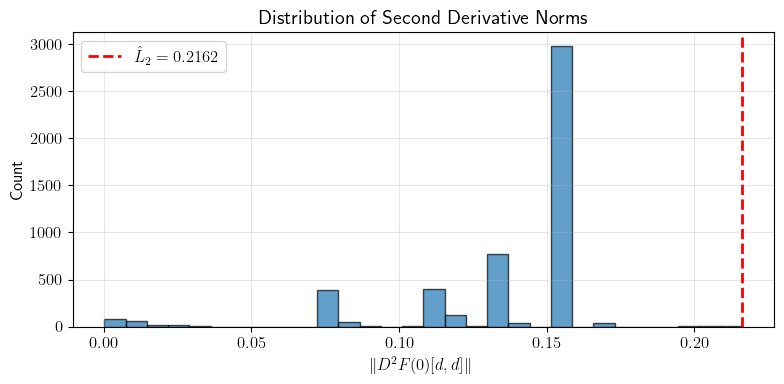

In [24]:
# Plot distribution of second derivative norms
fig, ax = plt.subplots(figsize=(8, 4))

ax.hist(second_deriv_norms.numpy(), bins=30, edgecolor='black', alpha=0.7)
ax.axvline(x=L2_hat, color='red', linestyle='--', linewidth=2, label=f'$\\hat{{L}}_2 = {L2_hat:.4f}$')

ax.set_xlabel(r'$\|D^2 F(0)[d,d]\|$')
ax.set_ylabel('Count')
ax.set_title('Distribution of Second Derivative Norms')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 5: Compute Condition Number $\kappa(V)$

The Bauer-Fike theorem requires the condition number of the eigenvector matrix $V$:
$$\kappa(V) = \|V\|_2 \|V^{-1}\|_2$$

In [25]:
# Eigenvector matrix V (columns are eigenvectors)
V = eigvecs

# Condition number of V
# For complex matrices, use SVD
V_svd = torch.linalg.svdvals(V)
kappa_V = (V_svd.max() / V_svd.min()).item()

print(f"Singular values of V: {V_svd}")
print(f"Condition number κ(V) = {kappa_V:.4f}")

Singular values of V: tensor([1.7933, 0.8600, 0.1819, 0.1068])
Condition number κ(V) = 16.7911


## Step 6: Verify Stability Criterion

The sufficient condition for $J_{cl}$ to be Hurwitz is:
$$\kappa(V) \cdot \frac{1}{2} L_2 h \frac{n}{\sqrt{N}} \leq \hat{\lambda}$$

where:
- $\kappa(V)$ is the condition number of the eigenvector matrix
- $L_2$ is the Hessian bound
- $h$ is the perturbation radius
- $n$ is the state dimension
- $N$ is the number of samples
- $\hat{\lambda} = -\max_i \text{Re}(\hat{\lambda}_i)$ is the stability margin

In [26]:
# Estimation error bound
error_bound = kappa_V * 0.5 * L2 * h * n / np.sqrt(N)

print("="*60)
print("STABILITY CERTIFICATION RESULTS")
print("="*60)
print(f"\nParameters:")
print(f"  Perturbation radius h = {h}")
print(f"  Number of samples N = {N}")
print(f"  State dimension n = {n}")
print(f"\nEstimates:")
print(f"  Condition number κ(V) = {kappa_V:.4f}")
print(f"  Hessian bound L_2 = {L2:.4f}")
print(f"  Stability margin λ̂ = {lambda_hat:.6f}")
print(f"\nStability Criterion:")
print(f"  Error bound = κ(V) · (1/2) · L_2 · h · n / √N")
print(f"             = {kappa_V:.4f} · 0.5 · {L2:.4f} · {h} · {n} / √{N}")
print(f"             = {error_bound:.6f}")
print(f"\n  Stability margin λ̂ = {lambda_hat:.6f}")
print(f"\nCondition: Error bound ≤ λ̂?")
print(f"           {error_bound:.6f} ≤ {lambda_hat:.6f}?")

if error_bound <= lambda_hat and lambda_hat > 0:
    print(f"\n✓ CERTIFIED: The closed-loop system is locally exponentially stable!")
    print(f"  The true Jacobian J_cl is guaranteed to be Hurwitz.")
elif lambda_hat <= 0:
    print(f"\n✗ NOT CERTIFIED: λ̂ ≤ 0, the estimated Jacobian is not Hurwitz.")
else:
    print(f"\n⚠ INCONCLUSIVE: Error bound exceeds stability margin.")
    print(f"  Try increasing N (more samples) or decreasing h (smaller perturbations).")
    
    # Suggest required N for certification
    if lambda_hat > 0:
        required_N = (kappa_V * 0.5 * L2 * h * n / lambda_hat) ** 2
        print(f"  Suggested N for certification: ≥ {int(np.ceil(required_N))}")

STABILITY CERTIFICATION RESULTS

Parameters:
  Perturbation radius h = 0.01
  Number of samples N = 5000
  State dimension n = 4

Estimates:
  Condition number κ(V) = 16.7911
  Hessian bound L_2 = 0.3242
  Stability margin λ̂ = -1.001025

Stability Criterion:
  Error bound = κ(V) · (1/2) · L_2 · h · n / √N
             = 16.7911 · 0.5 · 0.3242 · 0.01 · 4 / √5000
             = 0.001540

  Stability margin λ̂ = -1.001025

Condition: Error bound ≤ λ̂?
           0.001540 ≤ -1.001025?

✗ NOT CERTIFIED: λ̂ ≤ 0, the estimated Jacobian is not Hurwitz.


## Visualization: Estimation Error Analysis

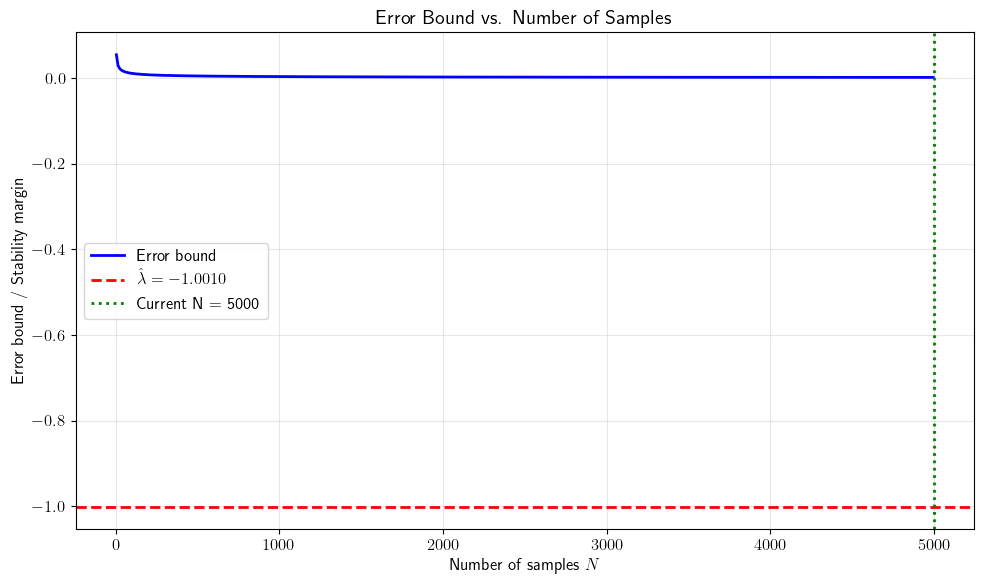

In [31]:
# Analyze how the error bound scales with N
N_values = np.arange(n, 5000, 10)
error_bounds = kappa_V * 0.5 * L2 * h * n / np.sqrt(N_values)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(N_values, error_bounds, 'b-', linewidth=2, label='Error bound')
ax.axhline(y=lambda_hat, color='red', linestyle='--', linewidth=2, label=f'$\\hat{{\\lambda}} = {lambda_hat:.4f}$')
ax.axvline(x=N, color='green', linestyle=':', linewidth=2, label=f'Current N = {N}')

# Find intersection point
if lambda_hat > 0:
    N_critical = (kappa_V * 0.5 * L2 * h * n / lambda_hat) ** 2
    if N_critical < N_values[-1]:
        ax.axvline(x=N_critical, color='orange', linestyle='-.', linewidth=2, 
                   label=f'Critical N = {N_critical:.0f}')

ax.set_xlabel('Number of samples $N$')
ax.set_ylabel('Error bound / Stability margin')
ax.set_title('Error Bound vs. Number of Samples')
ax.legend()
ax.grid(True, alpha=0.3)
# ax.set_xlim([N_values[0], N_values[-1]])

plt.tight_layout()
plt.show()

## Summary Statistics

In [28]:
# Compute singular values of D for analysis
D_svd = torch.linalg.svdvals(D)
sigma_min_D = D_svd.min().item()

print("Summary Statistics")
print("="*60)
print(f"\nDirection Matrix D:")
print(f"  Shape: {D.shape}")
print(f"  σ_min(D) = {sigma_min_D:.4f}")
print(f"  σ_max(D) = {D_svd.max().item():.4f}")
print(f"  Expected σ_min for i.i.d. isotropic: √(N/n) = {np.sqrt(N/n):.4f}")

print(f"\nEstimated Jacobian J_hat:")
print(f"  Frobenius norm: {J_hat.norm().item():.4f}")
print(f"  Spectral norm: {torch.linalg.svdvals(J_hat).max().item():.4f}")

print(f"\nEstimation Error Bound Components:")
print(f"  ||R||_2 ≤ (1/2) L_2 h √n = {0.5 * L2 * h * np.sqrt(n):.6f}")
print(f"  ||D^T(DD^T)^{{-1}}||_2 = 1/σ_min(D) = {1/sigma_min_D:.4f}")
print(f"  ||ΔJ_cl||_2 ≤ {0.5 * L2 * h * np.sqrt(n) / sigma_min_D:.6f}")

Summary Statistics

Direction Matrix D:
  Shape: torch.Size([4, 5000])
  σ_min(D) = 35.0083
  σ_max(D) = 35.8024
  Expected σ_min for i.i.d. isotropic: √(N/n) = 35.3553

Estimated Jacobian J_hat:
  Frobenius norm: 1.9992
  Spectral norm: 1.0117

Estimation Error Bound Components:
  ||R||_2 ≤ (1/2) L_2 h √n = 0.003242
  ||D^T(DD^T)^{-1}||_2 = 1/σ_min(D) = 0.0286
  ||ΔJ_cl||_2 ≤ 0.000093
